In [1]:
import os
import time

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
from joblib import Parallel, delayed
from fidelity_analysis.pulse import RectangularReadoutPulse
from fidelity_analysis.fidelity_simulation import FidelitySimulation
from fidelity_analysis.utils import UnitConverter, setup_plotting
import seaborn as sns
from fidelity_analysis.utils import S2pUtils

setup_plotting()

In [2]:
current_path = os.path.abspath("")
fidelity_data_dir_path = os.path.join(current_path, "fidelity_analysis", "data")
floquet_data_dir_path = os.path.join(current_path, "floquet_analysis", "data")
images_dir_path = os.path.join(current_path, "images")
data_dir_path = os.path.join(current_path, "data")

time_string = time.strftime("%Y%m%d-%H%M%S")

In [3]:
# Measured frequencies GHz

f01_meas = 3.845965050
f12_meas = 3.602264855
alpha = f12_meas - f01_meas

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

kappa_div2pi = 0.55 * 1e-3

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [4]:
# Define parameters for the readout pulse
f_pulse = (fr0_meas + fr1_meas) / 2 * 10 ** 9  # Hz

pulse_length = 2 * 10 ** (-6)  # s
total_signal_time = 2 * 2 * 10 ** (-6)  # s

pulse_samples_number = 2 ** 17

# Photon Number $n_r(t, \Delta, P_\text{in})$ Plots

 /var/folders/4v/sw011n6n73n99lwpjk6j8klm0000gp/T/ipykernel_85221/187901316.py: 2RuntimeWarning: invalid value encountered in multiply
 /Users/user/PycharmProjects/qubit_readout_simulation/fidelity_analysis/utils.py: 42UserWarning: The following kwargs were not used by contour: 'shading'
 /var/folders/4v/sw011n6n73n99lwpjk6j8klm0000gp/T/ipykernel_85221/187901316.py: 59

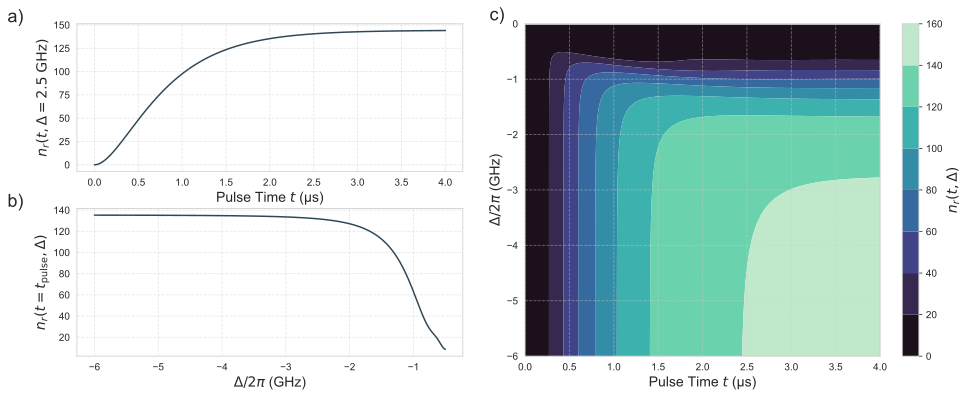

In [18]:
def chi(delta_val):
    return g_fitted ** 2 / delta_val * (1 / (1 + delta_val / alpha))


converter = UnitConverter()
P_in = converter.dbm_to_watts(-123)
kappa_total = kappa_div2pi * 1e9 * 2 * np.pi
kappa_ext = kappa_total
t_pulse = 2e-6  # s
omega_d = (fr0_meas + fr1_meas) * 1e9 / 2 * 2 * np.pi

t_arr = np.linspace(0, 2 * t_pulse, 1000)
delta_detuning = -1 * np.linspace(0.5, 6, 1000)

Delta_arr = chi(delta_detuning) * 1e9

time_dep = lambda t: converter.power2photons(P_in, t, kappa_total, kappa_ext, omega_d, chi(-2.5))
power2photons_delta_dep = lambda Delta: converter.power2photons(P_in, t_pulse, kappa_total, kappa_ext, omega_d, Delta)

# Regrouped layout:
# Left column: two line plots stacked vertically
# Right column: 2D plot spanning full height
fig = plt.figure(figsize=(16, 6), dpi=300)
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    width_ratios=[1.0, 1.15],
    height_ratios=[1, 1],
    wspace=0.15, # Adjusted for label space
    hspace=0.25
)

ax_time = fig.add_subplot(gs[0, 0])
ax_delta = fig.add_subplot(gs[1, 0])
ax_2d = fig.add_subplot(gs[:, 1])

# Subplot (top-left): time dependence
ax_time.plot(t_arr * 1e6, time_dep(t_arr))
ax_time.set_xlabel(r"Pulse Time $t$ (µs)")
ax_time.set_ylabel(r"$n_r(t, \Delta=2.5 \;\mathrm{GHz})$")
ax_time.text(-0.18, 1.1, "a)", transform=ax_time.transAxes, va="top", ha="left", fontsize=18)

# Subplot (bottom-left): detuning dependence
ax_delta.plot(delta_detuning, power2photons_delta_dep(Delta_arr))
ax_delta.set_xlabel(r"$\Delta/2\pi$ (GHz)")
ax_delta.set_ylabel(r"$n_r(t=t_\mathrm{pulse}, \Delta)$")
ax_delta.text(-0.18, 1.1, "b)", transform=ax_delta.transAxes, va="top", ha="left", fontsize=18)

# Subplot (right): 2D grid (time and Δ/2π)
t_grid = np.linspace(0, 2 * t_pulse, 800)  # s
delta_grid = -1 * np.linspace(0, 6, 400)  # GHz
Delta_rad_grid = chi(delta_grid) * 1e9  # rad/s

T = t_grid[None, :]
Delta_mat = Delta_rad_grid[:, None]
photons_grid = converter.power2photons(P_in, T, kappa_total, kappa_ext, omega_d, Delta_mat)

cmap = sns.color_palette("mako", as_cmap=True)

im = ax_2d.contourf(
    t_grid * 1e6,  # µs
    delta_grid,  # GHz
    photons_grid,
    cmap=cmap,
    shading="auto",
    zorder=-100
)
ax_2d.set_xlabel(r"Pulse Time $t$ (µs)")
ax_2d.set_ylabel(r"$\Delta/2\pi$ (GHz)")
cbar = fig.colorbar(im, ax=ax_2d)
cbar.set_label(r"$n_r(t, \Delta)$")
ax_2d.text(-0.1, 1.05, "c)", transform=ax_2d.transAxes, va="top", ha="left", fontsize=18)

#plt.tight_layout()
plt.savefig(os.path.join(images_dir_path, f"n_r_time_delta_and_2d_plot_{time_string}.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(images_dir_path, f"n_r_time_delta_and_2d_plot_{time_string}.png"), bbox_inches='tight')
plt.show()

# Fidelity($\Delta$, $n_r$) Grid Data Calculation

In [6]:
delta_arr = -1 * np.linspace(0.5, 6, 110)
n_r_for_background = np.linspace(1, 500, 250)

delta_for_background = delta_arr

Q = f_pulse * 1e-9 / kappa_div2pi


def fidelity_arr_for_n_photons(n_photons):
    fidelity_arr = []
    for delta in delta_for_background:
        chi_val = chi(delta) * 1e9
        state_0 = S2pUtils.create_resonator_S21(f_pulse + chi_val, Q, Q)
        state_1 = S2pUtils.create_resonator_S21(f_pulse - chi_val, Q, Q)
        P_in = converter.watts_to_dbm(
            converter.photons2power(n_photons, pulse_length, kappa_total, kappa_ext, omega_d, chi_val))

        rect_readout_pulse = RectangularReadoutPulse(
            carrier_frequency=f_pulse,
            pulse_duration=pulse_length,
            pulse_power_dbm=P_in,
            total_signal_time=total_signal_time,
            pulse_samples_number=pulse_samples_number,
        )

        fidelity_simulation = FidelitySimulation(
            s_parameters_file_state_0=state_0,
            s_parameters_file_state_1=state_1,
            readout_pulse=rect_readout_pulse,
            IQ_projection_frequency=6.2e9,
            num_iterations=500,
            readout_dt=1e-9,
            plot_pulses=False,
            plot_result=False,
            disable_progress_bar=True,
        )
        fidelity = fidelity_simulation.run()
        fidelity_arr.append(fidelity)
    return np.array(fidelity_arr)


fidelity_grid = Parallel(n_jobs=-1)(
    delayed(fidelity_arr_for_n_photons)(n_photons) for n_photons in tqdm(n_r_for_background,
                                                                         desc="Finding fidelity for different resonator frequencies and photon numbers/pulse powers")
)

fidelity_grid = np.array(fidelity_grid)

time_string = time.strftime("%Y%m%d-%H%M%S")

filename_fidelity = f"fidelity_grid_{time_string}.npy"

with open(os.path.join(data_dir_path, filename_fidelity), "wb") as f:
    np.save(f, delta_for_background)
    np.save(f, n_r_for_background)
    np.save(f, fidelity_grid)


Finding fidelity for different resonator frequencies and photon numbers/pulse powers: 100%|██████████| 250/250 [18:57:05<00:00, 272.90s/it]  


# Combined Results Plotting

In [7]:
# Loading saved data

critical_n_filename_state_0 = "n_critical_wd-3.5-9.5-150_n_r-2000_state_0_20250901-140811.npy"
critical_n_filename_state_1 = "n_critical_wd-3.5-9.5-150_n_r-2000_state_1_20250901-023939.npy"
critical_n_file_state_0 = os.path.join(floquet_data_dir_path, critical_n_filename_state_0)
critical_n_file_state_1 = os.path.join(floquet_data_dir_path, critical_n_filename_state_1)

result_min_loaded = [None, None]
result_max_loaded = [None, None]
result_ng0_loaded = [None, None]
result_mean_loaded = [None, None]
all_results_loaded = [None, None]

with open(critical_n_file_state_0, "rb") as f:
    result_min_loaded[0] = np.load(f)
    result_max_loaded[0] = np.load(f)
    result_ng0_loaded[0] = np.load(f)
    result_mean_loaded[0] = np.load(f)
    all_results_loaded[0] = np.load(f)

with open(critical_n_file_state_1, "rb") as f:
    result_min_loaded[1] = np.load(f)
    result_max_loaded[1] = np.load(f)
    result_ng0_loaded[1] = np.load(f)
    result_mean_loaded[1] = np.load(f)
    all_results_loaded[1] = np.load(f)

fidelity_file = filename_fidelity # "fidelity_grid_20250831-153218.npy"  #
with open(os.path.join(data_dir_path, fidelity_file), "rb") as f:
    delta_for_background = np.load(f)
    n_r_for_background = np.load(f)
    fidelity_grid = np.load(f)


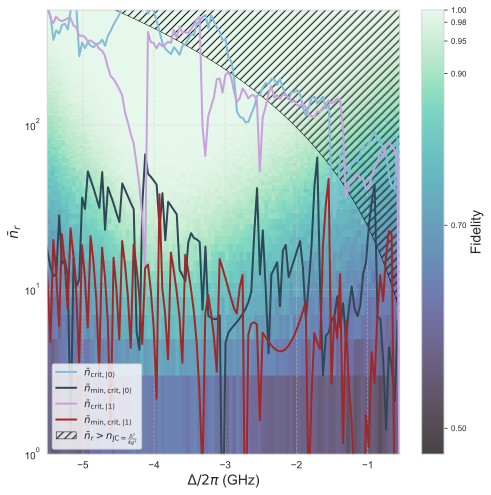

In [8]:
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

vmin = min(fidelity_grid.flatten())
vmax = max(fidelity_grid.flatten())

# Colormap and logarithmic scaling
cmap = sns.color_palette("mako", as_cmap=True)
norm = mcolors.LogNorm(vmin=vmin, vmax=vmax)  # log scale for colors

fig, axs = plt.subplots(1, 1, figsize=(7, 7))

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel(r'$\bar{n}_r$')
axs.set_yscale("log")

axs.plot(result_min_loaded[0][:, 1], result_mean_loaded[0], label=r"$\bar{n}_{{\rm crit}, |0\rangle}$", lw=2, c="C2")
axs.plot(result_min_loaded[0][:, 1], result_min_loaded[0][:, 0], label=r"$\bar{n}_{{\rm min, crit}, |0\rangle}$", lw=2,
         c="C0")

axs.plot(result_min_loaded[1][:, 1], result_mean_loaded[1], label=r"$\bar{n}_{{\rm crit}, |1\rangle}$", lw=2, c="C4")
axs.plot(result_min_loaded[1][:, 1], result_min_loaded[1][:, 0], label=r"$\bar{n}_{{\rm min, crit}, |1\rangle}$", lw=2,
         c="C1")

deltas_x_axis = result_min_loaded[1][:, 1]

axs.fill_between(deltas_x_axis, deltas_x_axis ** 2 / (2 * g_fitted) ** 2, 5000,
                       facecolor='none',  # No solid fill, only hatch
                       hatch='///',       # Tilted lines pattern (you can try '\\\\' for the other direction)
                       edgecolor='black',  # Color of the hatch lines
                       linewidth=0.5,
                       label=r"$\bar{n}_r>n_{\text{JC}=\frac{\Delta^2}{4g^2}}$"
                 )


im = axs.imshow(
    fidelity_grid,
    extent=(delta_for_background.min(), delta_for_background.max(),
            n_r_for_background.min(), n_r_for_background.max()),
    origin='lower', aspect='auto', alpha=0.75,
    cmap=cmap, norm=norm
)

# Colorbar with custom ticks
cbar = fig.colorbar(im, ax=axs)
cbar.set_label(r"Fidelity")

tick_values = [0.5, 0.7, 0.9, 0.95, 0.98, 1.0]

cbar.set_ticks(tick_values)
cbar.ax.yaxis.set_major_locator(mticker.FixedLocator(tick_values))
cbar.ax.yaxis.set_major_formatter(mticker.FixedFormatter([f"{v:.2f}" for v in tick_values]))

# Kill minor ticks/labels that add scientific notation
cbar.minorticks_off()
cbar.ax.yaxis.set_minor_locator(mticker.NullLocator())
cbar.ax.yaxis.set_minor_formatter(mticker.NullFormatter())

# Make the label sizes consistent
cbar.ax.tick_params(which='both', labelsize=8)

axs.set_xlim(-5.5, -0.55)
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(os.path.join(images_dir_path, f"detuning_nc_with_ng_{time_string}_exp.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(images_dir_path, f"detuning_nc_with_ng_{time_string}_exp.png"), bbox_inches='tight')

plt.show()


In [9]:
filename_fidelity

'fidelity_grid_20250920-160826.npy'